In [1]:
import tensorflow as tf
import matplotlib.pyplot
import math

/Users/phaniram/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
tf.reset_default_graph()

In [22]:
def reconstructImages(ae, data, index =10):
    fig,axes = plt.subplots(nrows = 10, ncols = 2, figsize=(50,50))
    for i in range(10):
        test = data.images[index+i]
        test = np.expand_dims(test,axis =0)
        fig.add_subplot()
        axes[i, 0].imshow(test.reshape(28,28))
        axes[i, 1].imshow(ae.predict(test).reshape(28,28))

In [23]:
def plot_sliding_across_each_Z(ae, mnist):
    index  = 100
    test_im = mnist.train.images[index]
    input_x=np.expand_dims(test_im,0)
    Z =ae.extract_Z(input_x)
    nrows = 10
    fig,axes = plt.subplots(nrows = nrows, ncols = 5, figsize=(50,50))
    for i in range(nrows):
        Z__ = np.copy(Z)
        slider = np.arange(0.0, 1.0, 0.2)
        col =0
        for slide in slider:
            Z__[0,i] = slide
            axes[i, col].imshow(ae.predict_using_Z(Z__).reshape(28,28))
            col+=1 

In [24]:
class HiddenLayer(object):
    def __init__(self, M1, M2, layer_num, activation=tf.nn.leaky_relu):
        self.activation = activation
        layer_num = str(layer_num)
        self.layer_num = layer_num
        r= math.sqrt(6) / math.sqrt(M1 + M2 + 1)
        self.W1 = tf.Variable(tf.random_normal(shape =(M1, M2), stddev=r), name = 'W1'+layer_num)
        self.b1 = tf.Variable(tf.random_normal(shape =(1, M2), stddev=r), name = 'b1'+ layer_num)                  
        self.W2 = tf.Variable(tf.random_normal(shape =(M2, M1), stddev=r), name = 'W2'+layer_num)
        self.b2 = tf.Variable(tf.random_normal(shape =(1, M1), stddev=r), name = 'b1'+ layer_num)
        self.params = [self.W1, self.W2]
                         
    def forward(self,X, encode = False, batch_norm = False): 
        if encode == True:
            l=tf.matmul(X, self.W1)+self.b1
            if batch_norm == True:
                ll = tf.nn.batch_normalization(l, mean = 0.5, variance = 0.02, offset=0, scale = 1, variance_epsilon=1e-5, name = 'encode'+ self.layer_num)       
        else:
            l=tf.matmul(X, self.W2)+self.b2
            if batch_norm == True:
                ll = tf.nn.batch_normalization(l, mean = 0.5, variance = 0.02, offset=0, scale = 1, variance_epsilon=1e-5, name = 'decode'+ self.layer_num)
        return self.activation(l)
    
    def layer_weight(self, norm = tf.nn.l2_loss):
        return norm(self.W1) + norm(self.W2)


In [25]:
class CSE674AutoEncoder():
    def __init__(self, n_input, hidden_layer_sizes ,rho=0.01, alpha=0.0001, beta=3, activation=tf.nn.sigmoid, optimizer=tf.train.AdamOptimizer()):
        self.n_input=n_input # input size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.rho=rho  # sparse parameters
        self.alpha =alpha
        self.beta=beta
        self.optimizer=optimizer
        
        self.X = tf.placeholder(tf.float32, shape =(None,n_input), name = 'X')
        self.encode_layers = []
        self.decode_layers = []
        self.layers_weights = []
        
        #designing the structure
        layer_num = 0
        M1 = n_input
        for M2 in hidden_layer_sizes:
            layer_num += 1
            layer = HiddenLayer(M1, M2 ,layer_num)
            M1 = M2
            self.encode_layers.append(layer)
            self.decode_layers.append(layer)
            
        output = self.X
        for layer in self.encode_layers:
            output = layer.forward(output, encode=True, batch_norm = False)
            layer_weight = layer.layer_weight()
            self.layers_weights += layer_weight
        
        self.Z = output
        output_decode = self.Z
        for layer in reversed(self.decode_layers):
            output_decode = layer.forward(output_decode, batch_norm = False)
            self.layers_weights += layer_weight
            
        self.X_hat = output_decode
        
        #now for prediction
        self.loss = self.loss(self.X)
        self.train_op  = self.optimizer.minimize(self.loss)
        
        # always initialize global variables after optimizer
        self.init_op = tf.global_variables_initializer()
        self.session = tf.InteractiveSession()
        
        self.session.run(self.init_op)    
            
    def kl_divergence(self, rho, rho_hat):
        #formula ρ: −ρlogh ̄j −(1−ρ)log(1−h ̄j)+constant
        return rho * tf.log(rho) - rho * tf.log(rho_hat) + (1 - rho) * tf.log(1 - rho) - (1 - rho) * tf.log(1 - rho_hat)
            
    def loss(self,X):
        H = self.Z
        rho_hat=tf.reduce_mean(H,axis=0)   #Average hidden layer over all data points in X, Page 14 in https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf
        kl=self.kl_divergence(self.rho, rho_hat)
        X_=self.X_hat
        diff=X-X_
        layers_weights_all= tf.reduce_sum(self.layers_weights, axis = 0)
        cost= 0.5*tf.reduce_mean(tf.reduce_sum(diff**2,axis=1)) + 0.5*(layers_weights_all) +self.beta*(kl)
        return cost
    
    def train_each_batch(self, X):
        return self.session.run([self.loss, self.train_op], feed_dict ={self.X:X})
    
    def predict(self, X):
        return self.session.run(self.X_hat, feed_dict={self.X:X})
    
    def extract_Z(self, X):
        return self.session.run(self.Z, feed_dict= {self.X:X})
    
    def predict_using_Z(self, Z):
        output_predict = Z 
        for layer in reversed(self.decode_layers):
            output_predict = layer.forward(output_predict, batch_norm = False)
        
        return self.session.run(output_predict)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
done
Reconstructed Images


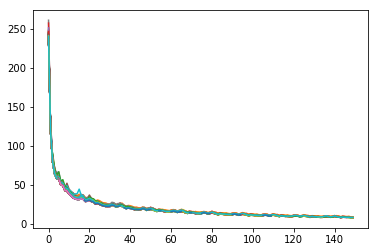

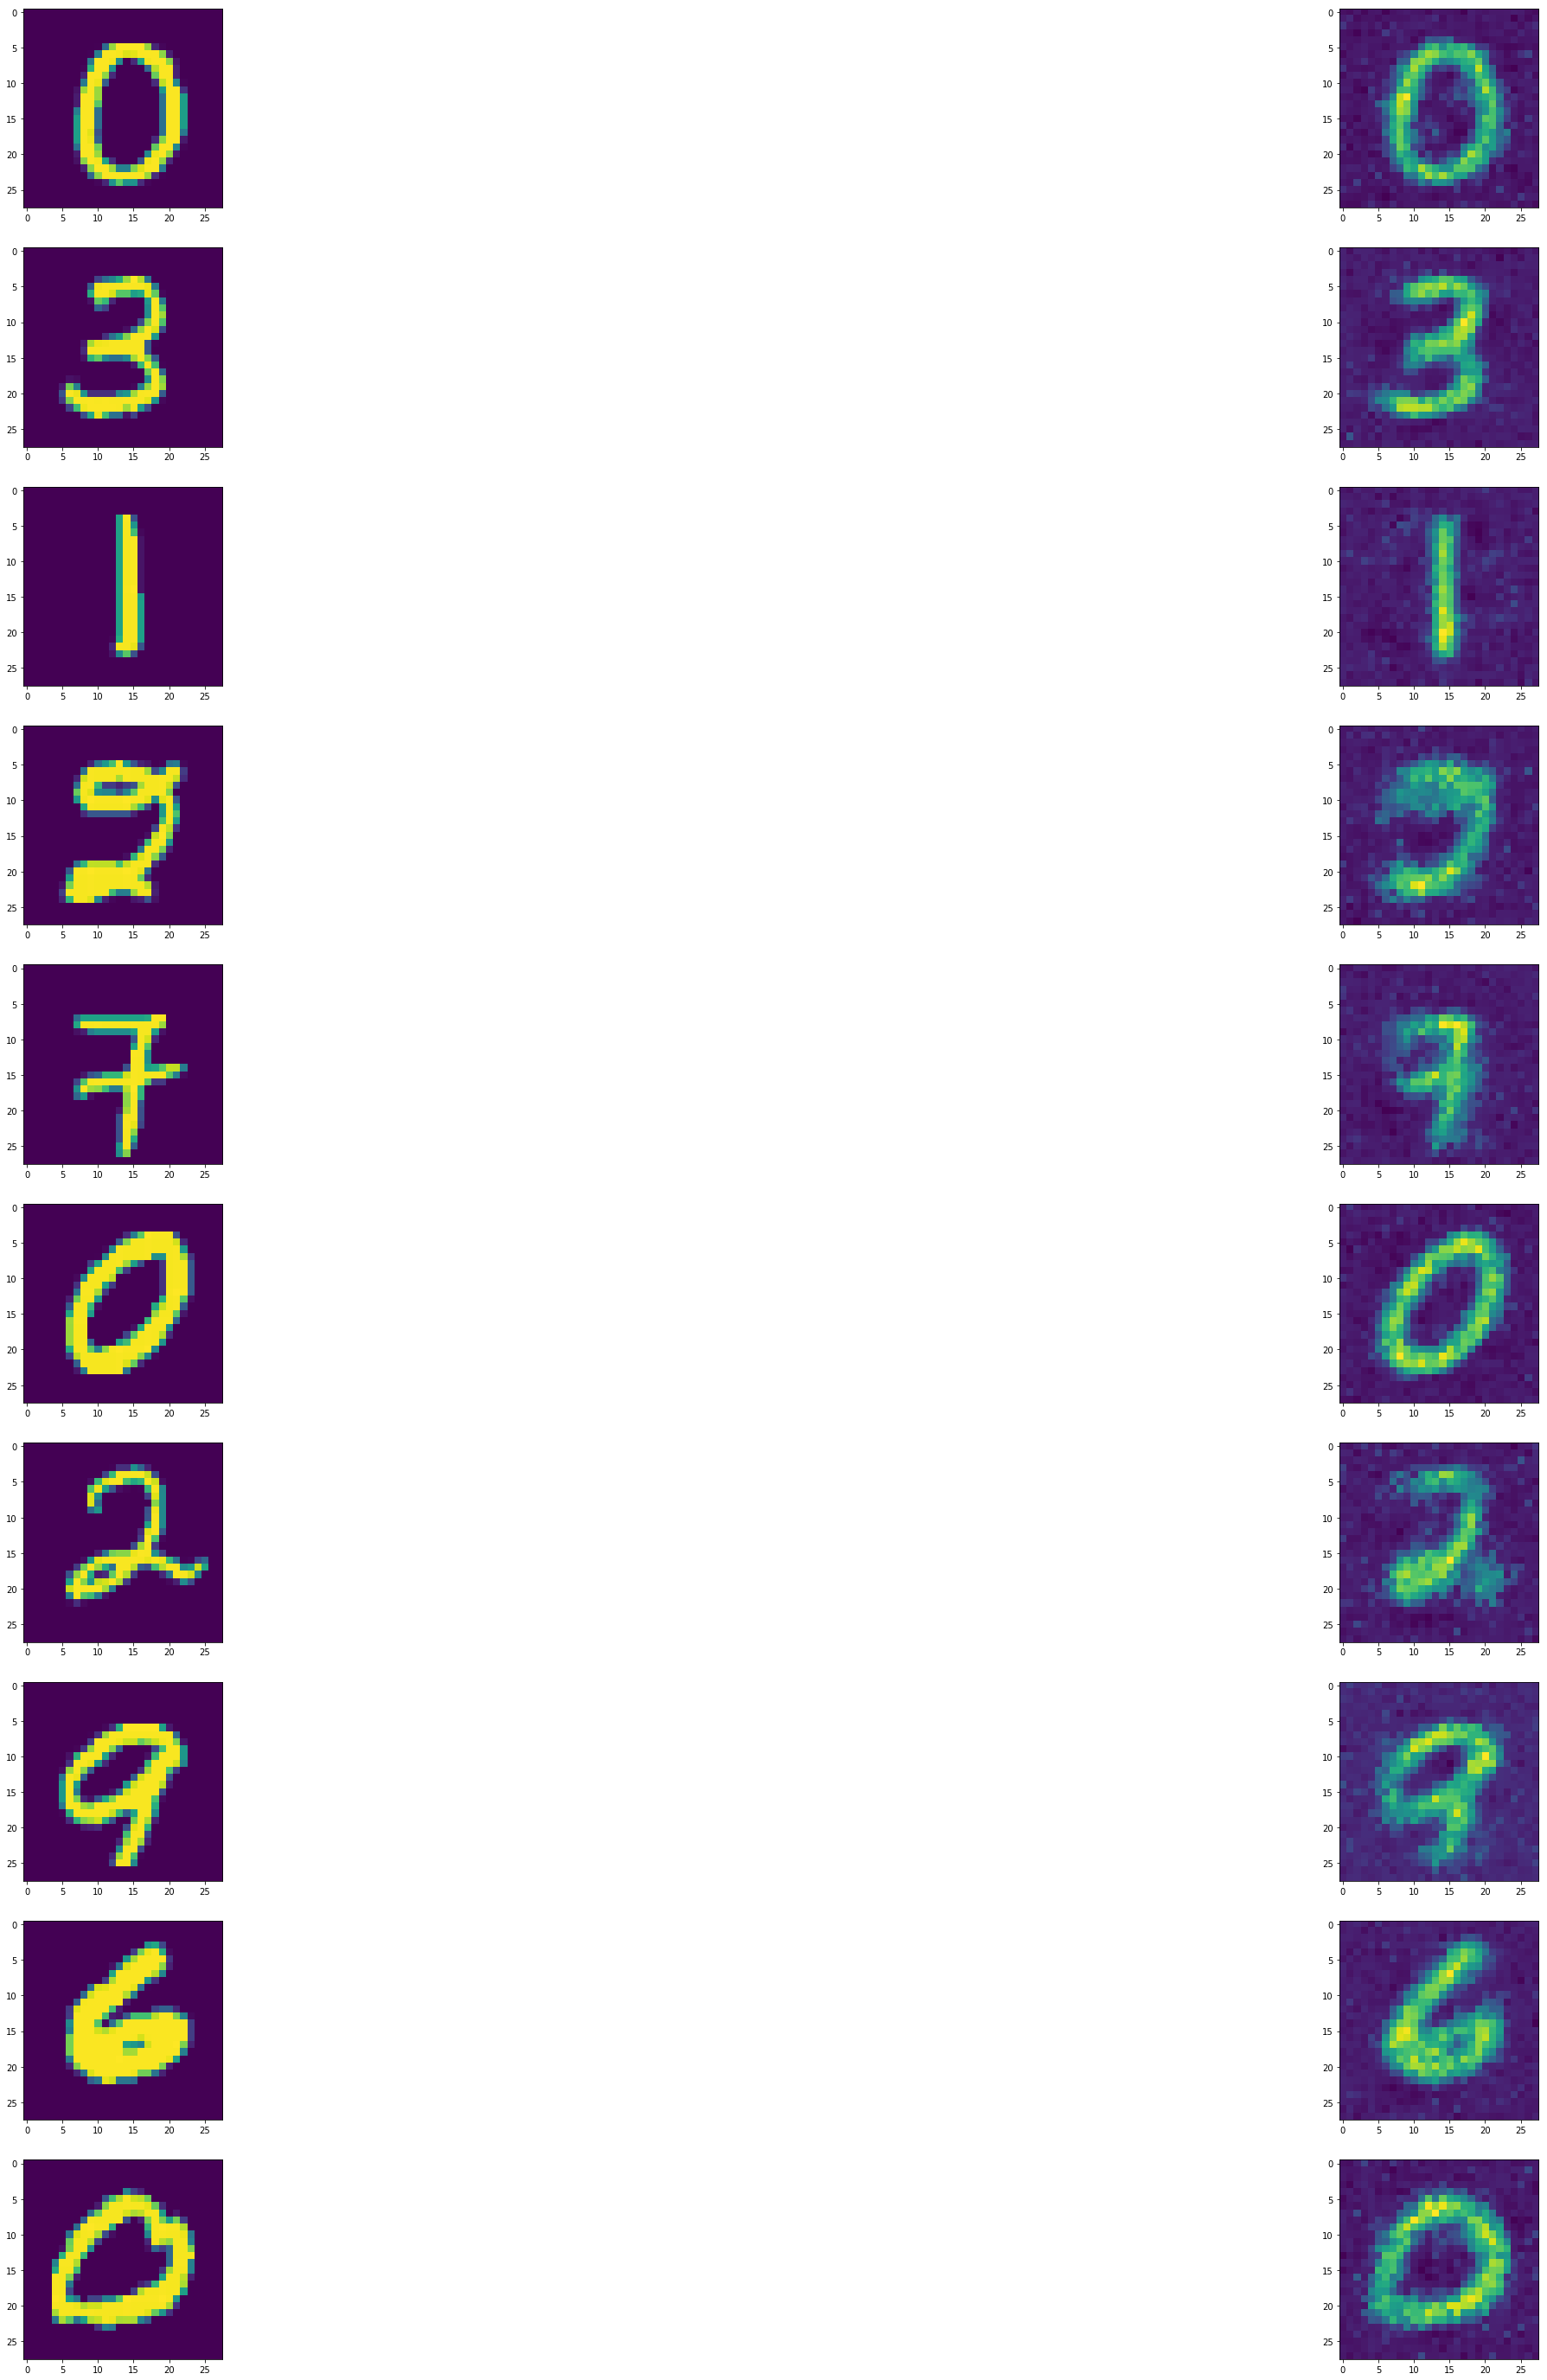

In [27]:
def mnist():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    mnist_train = mnist.train.images[:1000]
    
    #edit all the architecture at one place here:
    hidden_layer_sizes = [400, 200]
    
    
    batch_sz = 64
    n_inputs=784
    learning_rate=0.01
    
    ae =   CSE674AutoEncoder(n_inputs, hidden_layer_sizes)
    losses = []
    batch_num  = 0
    num_batches= mnist_train.shape[0]// batch_sz
    epochs = 10

    for i in range(epochs):
        for i in range(num_batches):
            batch =  mnist_train[batch_sz*i: batch_sz*(i+1)]
            loss,_ = ae.train_each_batch(batch)
            batch_num += 1
            losses.append(loss)
    print('done')
    plt.plot(losses)
    
    print('Reconstructed Images')
    reconstructImages(ae, mnist.train)
    
    #plot_sliding_across_each_Z(ae, mnist)
    
if __name__ == '__main__':
    mnist()